100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


Epoch [1/10], Loss: 0.0724
Epoch [2/10], Loss: 0.0531
Epoch [3/10], Loss: 0.0504
Epoch [4/10], Loss: 0.0484
Epoch [5/10], Loss: 0.0466
Epoch [6/10], Loss: 0.0454
Epoch [7/10], Loss: 0.0444
Epoch [8/10], Loss: 0.0438
Epoch [9/10], Loss: 0.0432
Epoch [10/10], Loss: 0.0428
Applying t-SNE... (this may take a minute)


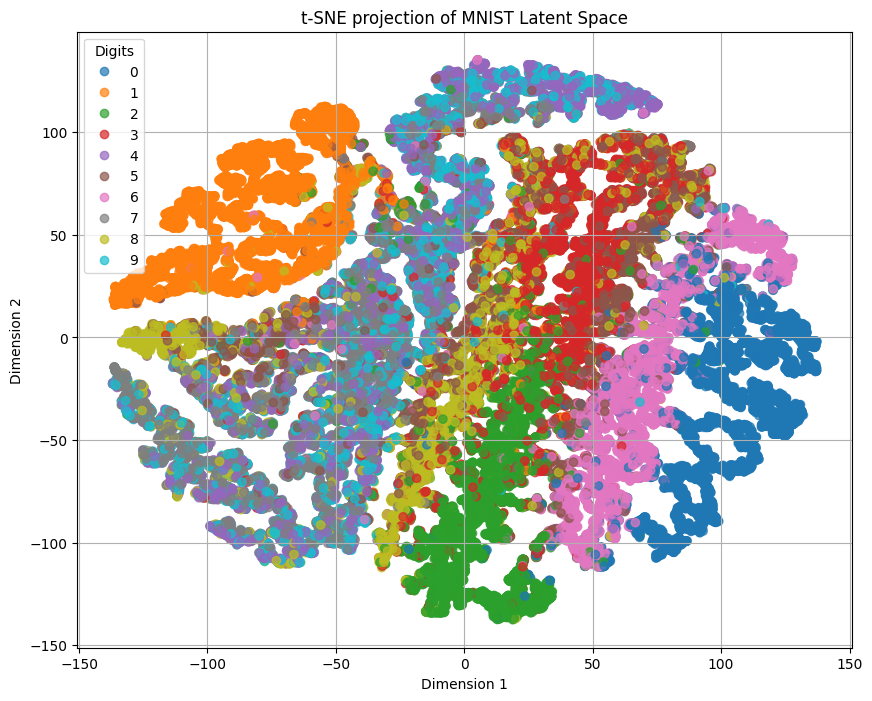


✅ End-to-End Project Completed: Latent Manifold Exploration Visualized!


In [ ]:
# 🚀 Exploring Latent Manifolds of MNIST Digits with Autoencoders and t-SNE

# Install required libraries
# !pip install torch torchvision matplotlib scikit-learn --quiet

# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Latent space 2D for easy t-SNE visualization
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Extract Latent Representations
latents = []
labels = []
model.eval()
with torch.no_grad():
    for images, targets in train_loader:
        images = images.view(images.size(0), -1).to(device)
        encoded = model.encoder(images)
        latents.append(encoded.cpu())
        labels.append(targets)

latents = torch.cat(latents, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

# Apply t-SNE for better visualization
print("Applying t-SNE... (this may take a minute)")

# Although our latent space is 2D already, applying t-SNE shows hidden curvature
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latents_2d = tsne.fit_transform(latents)

# Plot
plt.figure(figsize=(10,8))
scatter = plt.scatter(latents_2d[:,0], latents_2d[:,1], c=labels, cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("t-SNE projection of MNIST Latent Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

print("\n✅ End-to-End Project Completed: Latent Manifold Exploration Visualized!")


In [ ]:
import umap

# Apply UMAP for dimensionality reduction
print("Applying UMAP... (this may take a few seconds)")

umap_reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=42)
latents_2d = umap_reducer.fit_transform(latents)


Applying UMAP... (this may take a few seconds)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


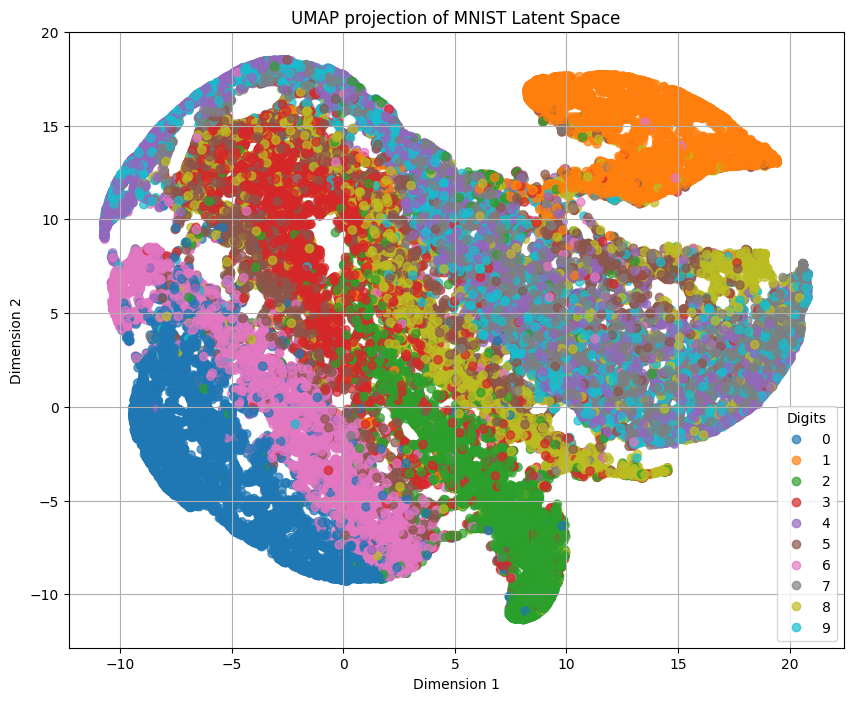

In [ ]:
# Plotting
plt.figure(figsize=(10,8))
scatter = plt.scatter(latents_2d[:,0], latents_2d[:,1], c=labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("UMAP projection of MNIST Latent Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


In [ ]:
import pickle
import os
from google.colab import files

# Create a directory to store artifacts
os.makedirs('saved_artifacts', exist_ok=True)

# 1. Save the trained Autoencoder model
MODEL_SAVE_PATH = 'saved_artifacts/autoencoder_mnist.pth'
torch.save(model.state_dict(), MODEL_SAVE_PATH)

# 2. Save the 2D embeddings (current latents_2d)
LATENTS_2D_SAVE_PATH = 'saved_artifacts/2d_latents_labels.pkl'
with open(LATENTS_2D_SAVE_PATH, 'wb') as f:
    pickle.dump({'embeddings_2d': latents_2d, 'labels': labels}, f)

# 3. Save the raw latent embeddings (before t-SNE or UMAP)
LATENT_SAVE_PATH = 'saved_artifacts/latent_vectors.pkl'
with open(LATENT_SAVE_PATH, 'wb') as f:
    pickle.dump({'latent_vectors': latents, 'labels': labels}, f)

print("\n✅ Autoencoder, 2D Embeddings, and Latent Vectors saved successfully!")

# 4. Optional: Download them directly
files.download(MODEL_SAVE_PATH)
files.download(LATENTS_2D_SAVE_PATH)
files.download(LATENT_SAVE_PATH)



✅ Autoencoder, 2D Embeddings, and Latent Vectors saved successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>